# Step-by-step: Building auto-encoder by PyTorch

## Overview
+ Review Pytorch: Basic part when training a deep neural network
    + Loss function
    + Optimizer
+ Example: Unsupervised learning via Auto-Encoder
    + Autoencoder target
    + Data
    + Network building
    + Training
    + Hand-written digits recognition


## Review PyTorch: Basic parts when training a deep neural network


### Loss function 

Loss function decides how the model should be trained and what it is expected to learn.
Training neural network is the process of looking for weights which can minimize the value of loss function. Then the model weight is updated by Backpropagation. 

For Backpropagation: the gradients of the loss with respect to the model weight will be calculated. Each weight value will be updated based on this gradient.  

Autoencoder loss function example:

![tensorflow_loss](assets/loss.png)

### Optimizer

Optimizer will update the weight based on the gradient calculated. It will decide how fast the weight update (learning rate), which parameters to update(params) and so on. There are lots of different propagation algorithms which leads to different optimizers, e.g. Stochastic Gradient Descent (SGD), Root Mean Square Propagation (RMSprop), Adam.

## Example: Unsupervised learning via Auto-Encoder

### Autoencoder Target
+ Reconstruct an image
+ Learn a compressed image information: image representation

### Data
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. Images are in size (28, 28) and grayscale.

![mnist_examples](assets/mnist_examples.png)



In [2]:
# import the Torch package to save your day
# transforms are used to preprocess the images, e.g. crop, rotate, normalize, etc
import torch
from torchvision import datasets,transforms

# specific the data path in which you would like to store the downloaded files
# here, we save it to the folder called "mnist_data"
# ToTensor() here is used to convert data type to tensor, so that can be used in network

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

print(train_dataset)

batchSize=128

#only after packed in DataLoader, can we feed the data into the neural network iteratively
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
    StandardTransform
Transform: ToTensor()


Before feeding images into the network,
we should visualise them to make sure they are the same as our expectation.

To that end,
we define a function named `imshow` and torch library build in function `make_grid` to arrange and display them.

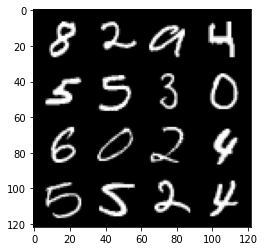

In [4]:
# package we used to manipulate matrix
import numpy as np
# package we used for image processing
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function     
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# load the first 16 training samples from next iteration
# [:16,:,:,:] for the 4 dimension of examples, first dimension take first 16, other dimension take all data
# arrange the image in grid
examples, _ = next(iter(train_loader))
example_show=make_grid(examples[:16,:,:,:], 4)

# then display them
imshow(example_show)



### Network building

The image data are loaded as our expectation, 
then we are going to build the Auto-Encoder in a fully-connected style as following:

![network_structure](assets/structure.png)

Our auto-encoder network consists of two parts, namely the Encoder and Decoder.
There are two fully-connected layers followed by sigmoid activation function in each part.  
The encoder will map the input from 784 to 256 and finally 128, which is termed as the representation of input.  
The 128-dim representation will then be fed into the decoder, 
and the decoder will try to project it back to the original space.

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Network Parameters
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 2nd layer num features (the latent dim)
num_input = 784  # MNIST data input (img shape: 28*28)


# Building the encoder
class Autoencoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2):
        super(Autoencoder, self).__init__()
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        # decoder part
        self.fc3 = nn.Linear(h_dim2, h_dim1)
        self.fc4 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def decoder(self, x):
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# When initialzing, it will run __init__() function as above
model = Autoencoder(num_input, num_hidden_1, num_hidden_2)
# If using GPU, model need to be set on cuda()
model.cuda()


Autoencoder(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
)

### Training

After we done with building the network, the next step is to train it.
There are a few questions we need to figure out before writing the code:

1. What's the cost function we are going to use?
    MSE loss for image reconstruction.

2. What's the optimization algorithm (optimizer) we are going to use?
    Adam.
    
3. How many epochs we are going to train?
    100

4. What's the learning rate?
    0.01

5. What's the batch size?
    128

With all these questions answered,
we now are able to train the network

In [14]:
# define loss and parameters
optimizer = optim.Adam(model.parameters())
epoch = 100
# MSE loss will calculate Mean Squared Error between the inputs 
loss_function = nn.MSELoss()

print('====Training start====')
for i in range(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # prepare input data
        data = data.cuda()        
        inputs = torch.reshape(data,(-1, 784)) # -1 can be any value. So when reshape, it will satisfy 784 first

        # set gradient to zero
        optimizer.zero_grad()
        
        # feed inputs into model
        recon_x = model(inputs)
        
        # calculating loss 
        loss = loss_function(recon_x, inputs)
        
        # calculate gradient of each parameter
        loss.backward()
        train_loss += loss.item()
        
        # update the weight based on the gradient calculated
        optimizer.step()
        
    if i%10==0:    
        print('====> Epoch: {} Average loss: {:.9f}'.format(i, train_loss ))
print('====Training finish====')

====Training start====
====> Epoch: 0 Average loss: 30.795022525
====> Epoch: 10 Average loss: 5.668834789
====> Epoch: 20 Average loss: 3.436712719
====> Epoch: 30 Average loss: 2.559106469
====> Epoch: 40 Average loss: 2.112858875
====> Epoch: 50 Average loss: 1.834778405
====> Epoch: 60 Average loss: 1.644337426
====> Epoch: 70 Average loss: 1.503316402
====> Epoch: 80 Average loss: 1.396759466
====> Epoch: 90 Average loss: 1.308020757
====Training finish====


### Have a look of the output:

Now, we success to get a trained auto-encoder using no manual labels.  
we then use it to reconstruct the testing samples to see how the output images look like


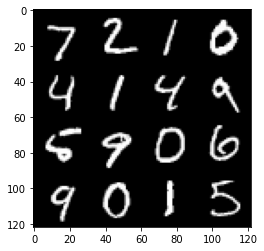

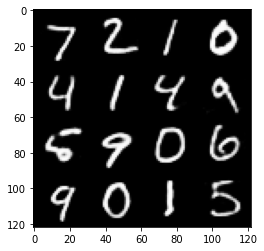

In [15]:
# load 16 images from testset
inputs, _ = next(iter(test_loader))
inputs_example = make_grid(inputs[:16,:,:,:],4)
imshow(inputs_example)

#convert from image to tensor
inputs=inputs.cuda()
inputs=torch.reshape(inputs,(-1,784))

# get the outputs from the trained model
outputs=model(inputs)

#convert from tensor to image
outputs=torch.reshape(outputs,(-1,1,28,28))
outputs=outputs.detach().cpu()

#show the output images
outputs_example = make_grid(outputs[:16,:,:,:],4)
imshow(outputs_example)


### Evaluation: Handwritten digit images recognition

After training the auto-encoder,
we can now use the model to reconstruct some images.
But we already got the images, why we need the model to reconstruct it for us? What else can the model do?

Actually,
in order to reconstruct different training images,
the model has learned to recognise how the image looks like and describe it in the 128-dim latent space.
In other words,
the visual information of images is compressed and encoded in the 128-dim representations.
As we assume that samples from the same categories should be more visually similar than those from different classes,
the representations can then be used for image recognition, *i.e.,* handwritten digit images recognition in our case.

One simple way to recognise images is,
we randomly pick 10 training samples from each class and annotate them with label.
Then given the test data, we can predict which classes they belong to by finding the most similar labelled training samples to them.

![tensorflow_layers](assets/representation_class.png)

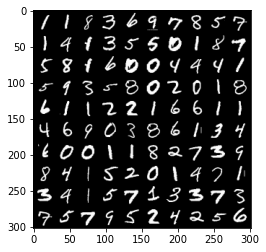

tensor([[1, 1, 8, 3, 6, 9, 7, 8, 5, 7],
        [1, 4, 1, 3, 5, 5, 0, 1, 8, 7],
        [5, 8, 1, 6, 0, 0, 4, 4, 4, 1],
        [5, 9, 3, 5, 8, 0, 2, 0, 1, 8],
        [6, 1, 1, 2, 2, 1, 6, 6, 1, 1],
        [4, 6, 9, 0, 3, 8, 6, 1, 3, 4],
        [6, 0, 0, 1, 1, 8, 2, 7, 3, 9],
        [8, 4, 1, 5, 2, 0, 1, 4, 7, 1],
        [3, 4, 1, 5, 7, 1, 3, 3, 7, 3],
        [7, 5, 7, 9, 5, 2, 4, 2, 5, 6]])


In [16]:
# get 100 image-label pairs from training set
x_train, y_train = next(iter(train_loader))

# 10 classes, 10 samples per class, 100 in total
candidates = np.random.choice(batchSize, 10*10)

# randomly select 100 samples
x_train = x_train[candidates]
y_train = y_train[candidates]

# display the selected samples and print their labels

imshow(make_grid(x_train[:100,:,:,:],10))
print(y_train.reshape(10, 10))

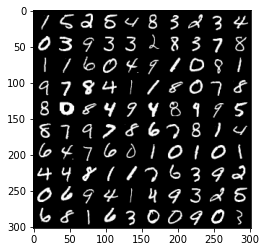

tensor([[1, 5, 2, 5, 4, 8, 3, 2, 3, 4],
        [0, 3, 9, 3, 3, 2, 8, 3, 7, 8],
        [1, 1, 6, 0, 4, 9, 1, 0, 8, 1],
        [9, 7, 8, 4, 1, 1, 8, 0, 7, 8],
        [8, 0, 8, 4, 9, 4, 8, 9, 9, 5],
        [8, 7, 9, 7, 8, 6, 7, 8, 1, 4],
        [6, 4, 7, 6, 0, 1, 0, 1, 0, 1],
        [4, 4, 8, 1, 1, 7, 6, 3, 9, 2],
        [0, 6, 9, 4, 1, 4, 9, 3, 2, 5],
        [6, 8, 1, 6, 3, 0, 0, 9, 0, 3]])


In [17]:
# get 100 image-label pairs from test set
x_test, y_test = next(iter(train_loader))
candidates_test = np.random.choice(batchSize, 10*10)

x_test = x_test[candidates_test]
y_test = y_test[candidates_test]

# display the selected samples and print their labels
imshow(make_grid(x_test[:100,:,:,:],10))

print(y_test.reshape(10, 10))

In [19]:
# compute the representations of training and test samples
h_train=model.encoder(torch.reshape(x_train.cuda(),(-1,784)))
h_test=model.encoder(torch.reshape(x_test.cuda(),(-1,784)))

# find the nearest training samples to each test instance, in terms of MSE
MSEs = np.mean(np.power(np.expand_dims(h_test.detach().cpu(), axis=1) - np.expand_dims(h_train.detach().cpu(), axis=0), 2), axis=2)
neighbours = MSEs.argmin(axis=1)
predicts = y_train[neighbours]

# print(np.stack([y_test, predicts], axis=1))
print('Recognition accuracy according to the learned representation is %.1f%%' % (100 * (y_test == predicts).numpy().astype(np.float32).mean()))


Recognition accuracy according to the learned representation is 71.0%
